In [1]:
! pip install scikit-plot

In [0]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import shutil

try:
    shutil.rmtree("fer13")
except Exception:
    pass

In [5]:
from zipfile import ZipFile 

file_name = "drive/My Drive/FER/datasets/final_u1.zip"
  
with ZipFile(file_name, 'r') as zip_:
    print('Extracting all the files...') 
    zip_.extractall("fer13")
    print('Done!')

Extracting all the files...
Done!


In [0]:
import os
import cv2
import dlib
import math
import numpy as np
from collections import OrderedDict

import scikitplot
import seaborn as sns
from matplotlib import pyplot

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D, Concatenate
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from keras import backend as K
from keras.utils import np_utils

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [0]:
np.random.seed(42)

In [0]:
DATA = "fer13"
DATA_PATH = "fer13/final/"
BASE_PATH = "drive/My Drive/FER/Colab/GauravSharma/Multi-Input-Model/"

In [9]:
class_count = {}
for dir_ in os.listdir(DATA_PATH):
    if not dir_.isupper():
        os.rename(DATA_PATH+dir_, DATA_PATH+dir_.title())
        dir_ = dir_.title()

    count = 0
    for f in os.listdir(DATA_PATH + dir_ + "/"):
        count += 1

    class_count[dir_] = count
    print(f"{dir_} has {count} number of images")

total_images = sum(class_count.values())
print(f"\ntotal images are {total_images}")

Angry has 966 number of images
Sadness has 1326 number of images
Fear has 859 number of images
Neutral has 1446 number of images
Happy has 2477 number of images

total images are 7074


In [10]:
TOP_EMOTIONS = ["Happy", "Neutral", "Sadness"]

for k,v in class_count.items():
    if not k in TOP_EMOTIONS:
        total_images -= v

total_images

5249

In [11]:
%%time

print("Extracting facial ROI, this may take some time")

face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor(BASE_PATH+"dumps/shape_predictor_68_face_landmarks.dat")

ROI_shape = (50,25)
ROI_1 = list(set(range(17,48)) - set(range(29,36)))
ROI_2 = list(range(48,68)) + [33, 4, 14]
roi1_arr = []
roi2_arr = []

inconsistent_images = []
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        print(f"processing {dir_} images...")

        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img = cv2.imread(DATA_PATH + dir_ + "/" + f, 0)
            img_ = cv2.resize(img, (96,96))

            faces = face_detector(img_)
            
            if faces:
                for face in faces:
                    ROI1_landmarks = []
                    ROI2_landmarks = []
                    landmarks = shape_predictor(img_, face)
                    for i in range(0, 68):
                        x = landmarks.part(i).x
                        y = landmarks.part(i).y
                        if i in ROI_1:
                            ROI1_landmarks.append((x,y))
                        if i in ROI_2:
                            ROI2_landmarks.append((x,y))

                    try:
                        (x, y, w, h) = cv2.boundingRect(np.array(ROI1_landmarks))
                        roi1 = img_[y:y+h, x:x+w]
                        roi1 = cv2.resize(roi1, ROI_shape, interpolation=cv2.INTER_CUBIC)
                    except Exception:
                        inconsistent_images.append(dir_ + "/" + f)
                        break

                    try:
                        (x, y, w, h) = cv2.boundingRect(np.array(ROI2_landmarks))
                        roi2 = img_[y:y+h, x:x+w]
                        roi2 = cv2.resize(roi2, ROI_shape, interpolation=cv2.INTER_CUBIC)
                    except Exception:
                        inconsistent_images.append(dir_ + "/" + f)
                        break

                    roi1_arr.append(np.expand_dims(roi1, axis=2))
                    roi2_arr.append(np.expand_dims(roi2, axis=2))
            else:
                inconsistent_images.append(dir_ + "/" + f)

print(f"\ntotal inconsistent images: {len(inconsistent_images)},\t fractions: {len(inconsistent_images) / total_images}")

roi1_arr = np.array(roi1_arr)
print("ROI1", roi1_arr.shape)

roi2_arr = np.array(roi2_arr)
print("ROI2", roi2_arr.shape)

print("\n")

Extracting facial ROI, this may take some time
processing Happy images...
processing Sadness images...
processing Neutral images...

total inconsistent images: 1012,	 fractions: 0.19279862831015432
ROI1 (4237, 25, 50, 1)
ROI2 (4237, 25, 50, 1)


CPU times: user 15.8 s, sys: 417 ms, total: 16.2 s
Wall time: 19.3 s


In [12]:
total_images -= len(inconsistent_images)
total_images

4237

In [13]:
%%time
img_arr = np.empty(shape=(total_images,48,48,1))
img_label = np.empty(shape=(total_images))
label_to_text = {}

i = 0
label = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            if not dir_ + "/" + f in inconsistent_images:
                img_arr[i] = np.expand_dims(cv2.imread(DATA_PATH + dir_ + "/" + f, 0), axis=2)
                img_label[i] = label
                i += 1
        print(f"loaded {dir_} images to numpy arrays")
        label_to_text[label] = dir_
        label += 1

img_label = np_utils.to_categorical(img_label)

print(img_arr.shape, img_label.shape)

print("\n")

loaded Happy images to numpy arrays
loaded Sadness images to numpy arrays
loaded Neutral images to numpy arrays
(4237, 48, 48, 1) (4237, 3)


CPU times: user 405 ms, sys: 114 ms, total: 519 ms
Wall time: 520 ms


In [14]:
label_to_text

{0: 'Happy', 1: 'Sadness', 2: 'Neutral'}

In [15]:
text_to_label = dict((v,k) for k,v in label_to_text.items())
text_to_label

{'Happy': 0, 'Neutral': 2, 'Sadness': 1}

In [0]:
img_arr = img_arr / 255.

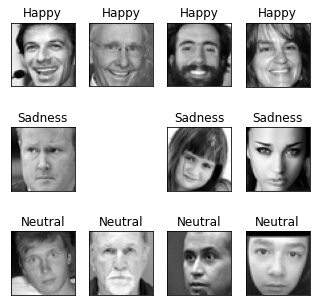

In [17]:
num_emotions = len(TOP_EMOTIONS)
fig = pyplot.figure(1, (num_emotions*1.5, num_emotions*1.5))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:,k]==1)[0], size=4, replace=False)
    sample_images = img_arr[sample_indices]
    for img in sample_images:
        idx += 1
        ax = pyplot.subplot(num_emotions,4,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])
        pyplot.tight_layout()

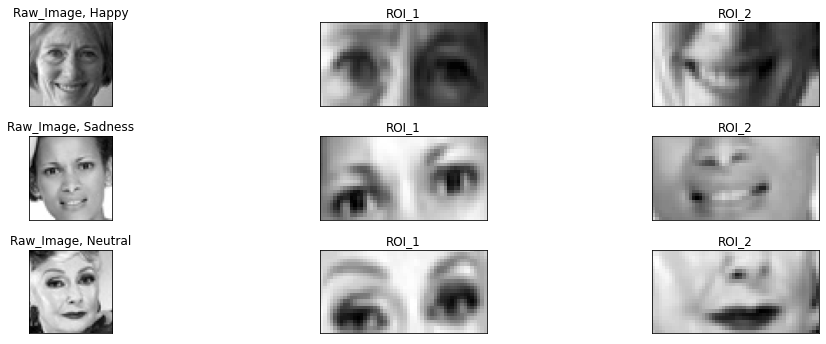

In [18]:
fig = pyplot.figure(1, (14,8))

np.random.seed(10)
idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:,k]==1)[0], size=1, replace=False)
    sample_images = img_arr[sample_indices]
    sample_roi1 = roi1_arr[sample_indices]
    sample_roi2 = roi2_arr[sample_indices]

    for img,roi1,roi2 in zip(sample_images, sample_roi1, sample_roi2):
        idx += 1
        ax = pyplot.subplot(5,3,idx)
        ax.imshow(img.reshape(48,48), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Raw_Image, {label_to_text[k]}")

        idx += 1
        ax = pyplot.subplot(5,3,idx)
        ax.imshow(roi1.reshape(ROI_shape[::-1]), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("ROI_1")

        idx += 1
        ax = pyplot.subplot(5,3,idx)
        ax.imshow(roi2.reshape(ROI_shape[::-1]), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title("ROI_2")

        pyplot.tight_layout()

In [0]:
def euclidean_dist(point_1: tuple, point_2: tuple) -> float:
    return math.sqrt((point_1[0]-point_2[0])**2 + (point_1[1]-point_2[1])**2)

In [127]:
# All in one
key_landmarks = {
    "kl_1": list(range(17,28)),
    "kl_2": [37,38,40,41],
    "kl_3": [43,44,46,47],
    "kl_4": [61,62,63],
    "kl_5": [65,66,67],
    "kl_6": [2,3,4,5,48],
    "kl_7": [11,12,13,14,54],
    "kl_8": [19,36,39],
    "kl_9": [24,42,45],
    "kl_10": [27,28,29,30],
    "kl_11": list(range(48, 60)),
}

kl_distances = []

NORMALIZE = False

face_detector = dlib.get_frontal_face_detector()
shape_predictor = dlib.shape_predictor(BASE_PATH+"dumps/shape_predictor_68_face_landmarks.dat")

for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        print(f"processing {dir_} images...")

        for f in os.listdir(DATA_PATH + dir_ + "/"):
            if not dir_ + "/" + f in inconsistent_images:
                img = cv2.imread(DATA_PATH + dir_ + "/" + f, 0)
                img_ = cv2.resize(img, (96,96))
                faces = face_detector(img_)

                if len(faces) != 1:
                    raise Exception(f"face count is {len(faces)}")

                key_landmarks_coords = {}
                for i in range(1,12):
                    key_landmarks_coords[f"kl_{i}"] = []

                key_landmarks_distance = {}

                for face in faces:
                    landmarks = shape_predictor(img_, face)
                    for i in range(0, 68):
                        x = landmarks.part(i).x
                        y = landmarks.part(i).y
                        for k in key_landmarks:
                            if i in key_landmarks[k]:
                                key_landmarks_coords[k].append((x,y))

                key_landmarks_distance["kl_dist_1"] = []
                for coords in key_landmarks_coords["kl_1"][:-1]:
                    key_landmarks_distance["kl_dist_1"].append(euclidean_dist(coords, key_landmarks_coords["kl_1"][-1]))

                key_landmarks_distance["kl_dist_2"] = []
                for coord1, coord2 in zip(key_landmarks_coords["kl_2"][:2], key_landmarks_coords["kl_2"][::-1][:2]):
                    key_landmarks_distance["kl_dist_2"].append(euclidean_dist(coord1, coord2))

                key_landmarks_distance["kl_dist_3"] = []
                for coord1, coord2 in zip(key_landmarks_coords["kl_3"][:2], key_landmarks_coords["kl_3"][::-1][:2]):
                    key_landmarks_distance["kl_dist_3"].append(euclidean_dist(coord1, coord2))

                key_landmarks_distance["kl_dist_4"] = []
                for coord1, coord2 in zip(key_landmarks_coords["kl_4"], key_landmarks_coords["kl_5"][::-1]):
                    key_landmarks_distance["kl_dist_4"].append(euclidean_dist(coord1, coord2))

                key_landmarks_distance["kl_dist_5"] = []
                for coord in key_landmarks_coords["kl_6"][:-1]:
                    key_landmarks_distance["kl_dist_5"].append(euclidean_dist(coord, key_landmarks_coords["kl_6"][-1]))

                key_landmarks_distance["kl_dist_6"] = []
                for coord in key_landmarks_coords["kl_7"][:-1]:
                    key_landmarks_distance["kl_dist_6"].append(euclidean_dist(coord, key_landmarks_coords["kl_7"][-1]))

                key_landmarks_distance["kl_dist_7"] = []
                for coord in key_landmarks_coords["kl_8"][1:]:
                    key_landmarks_distance["kl_dist_7"].append(euclidean_dist(coord, key_landmarks_coords["kl_8"][0]))

                key_landmarks_distance["kl_dist_8"] = []
                for coord in key_landmarks_coords["kl_9"][1:]:
                    key_landmarks_distance["kl_dist_8"].append(euclidean_dist(coord, key_landmarks_coords["kl_9"][0]))

                for i,coord1 in enumerate(key_landmarks_coords["kl_10"]):
                    key_landmarks_distance[f"kl_dist_{8+i+1}"] = []
                    for coord2 in key_landmarks_coords["kl_11"]:
                        key_landmarks_distance[f"kl_dist_{8+i+1}"].append(euclidean_dist(coord1,coord2))
                
                key_landmarks_distance = OrderedDict(sorted(key_landmarks_distance.items(), key=lambda i: int(i[0].split("_")[-1])))
                all_kl_dists = [i for v in key_landmarks_distance.values() for i in v]
                
                if NORMALIZE:
                    # all_kl_dists = [i/96 for i in all_kl_dists]
                    all_kl_dists = np.expand_dims(np.array(all_kl_dists),axis=1)
                    scaler = MinMaxScaler().fit(all_kl_dists)
                    all_kl_dists = scaler.transform(all_kl_dists)

                kl_distances.append(all_kl_dists)

kl_distances = np.array(kl_distances)
kl_distances.shape

processing Happy images...
processing Sadness images...
processing Neutral images...


(4237, 77)

In [128]:
hog_features = []
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        print(f"processing {dir_} images...")

        for f in os.listdir(DATA_PATH + dir_ + "/"):
            if not dir_ + "/" + f in inconsistent_images:
                img = cv2.imread(DATA_PATH + dir_ + "/" + f, 0)
                img_ = cv2.resize(img, (64,128))

                hog = cv2.HOGDescriptor()
                hog_descr = hog.compute(img_)
                hog_features.append(hog_descr)

hog_features = np.array(hog_features)
print(hog_features.shape)

processing Happy images...
processing Sadness images...
processing Neutral images...
(4237, 3780, 1)


In [129]:
Xtrain_img, Xtest_img, Xtrain_roi1, Xtest_roi1, Xtrain_roi2, Xtest_roi2, Xtrain_kldist, Xtest_kldist, Xtrain_hogfeat, Xtest_hogfeat, y_train, y_test =\
train_test_split(img_arr, roi1_arr, roi2_arr, kl_distances, hog_features, img_label,
                shuffle=True, stratify=img_label, train_size=0.85, random_state=42)

print(Xtrain_img.shape, Xtrain_roi1.shape, Xtrain_roi2.shape, Xtrain_kldist.shape, Xtrain_hogfeat.shape, y_train.shape)
print(Xtest_img.shape, Xtest_roi1.shape, Xtest_roi2.shape, Xtest_kldist.shape, Xtest_hogfeat.shape, y_test.shape)

(3601, 48, 48, 1) (3601, 25, 50, 1) (3601, 25, 50, 1) (3601, 77) (3601, 3780, 1) (3601, 3)
(636, 48, 48, 1) (636, 25, 50, 1) (636, 25, 50, 1) (636, 77) (636, 3780, 1) (636, 3)


In [0]:
def full_image_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_DCNN")
    
    conv2d_1 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1_img'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1_img')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2_img'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2_img')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1_img')(batchnorm_2)
    dropout_1 = Dropout(0.4, name='dropout_1_img')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3_img'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3_img')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4_img'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4_img')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2_img')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2_img')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5_img'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5_img')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6_img'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6_img')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3_img')(batchnorm_6)
    dropout_3 = Dropout(0.4, name='dropout_3_img')(maxpool2d_3)

    flatten = Flatten(name='flatten_dcnn_img')(dropout_3)
        
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_dcnn_img'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7_img')(dense_1)
    
    model_out = Dropout(0.6, name='dropout_4_img')(batchnorm_7)
    
    return model_in, model_out

In [0]:
def roi1_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_ROI1")
    
    conv2d_1 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1_roi1'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1_roi1')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2_roi1'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2_roi1')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1_roi1')(batchnorm_2)
    dropout_1 = Dropout(0.4, name='dropout_1_roi1')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3_roi1'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3_roi1')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4_roi1'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4_roi1')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2_roi1')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2_roi1')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5_roi1'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5_roi1')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6_roi1'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6_roi1')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3_roi1')(batchnorm_6)
    dropout_3 = Dropout(0.4, name='dropout_3_roi1')(maxpool2d_3)

    flatten = Flatten(name='flatten_roi1')(dropout_3)
        
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_roi1'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7_roi1')(dense_1)
    
    model_out = Dropout(0.6, name='dropout_4_roi1')(batchnorm_7)
    
    return model_in, model_out

In [0]:
def roi2_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_ROI2")
    
    conv2d_1 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1_roi2'
    )(model_in)
    batchnorm_1 = BatchNormalization(name='batchnorm_1_roi2')(conv2d_1)
    conv2d_2 = Conv2D(
        filters=32,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2_roi2'
    )(batchnorm_1)
    batchnorm_2 = BatchNormalization(name='batchnorm_2_roi2')(conv2d_2)
    
    maxpool2d_1 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_1_roi2')(batchnorm_2)
    dropout_1 = Dropout(0.4, name='dropout_1_roi2')(maxpool2d_1)

    conv2d_3 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3_roi2'
    )(dropout_1)
    batchnorm_3 = BatchNormalization(name='batchnorm_3_roi2')(conv2d_3)
    conv2d_4 = Conv2D(
        filters=64,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4_roi2'
    )(batchnorm_3)
    batchnorm_4 = BatchNormalization(name='batchnorm_4_roi2')(conv2d_4)
    
    maxpool2d_2 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_2_roi2')(batchnorm_4)
    dropout_2 = Dropout(0.4, name='dropout_2_roi2')(maxpool2d_2)

    conv2d_5 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5_roi2'
    )(dropout_2)
    batchnorm_5 = BatchNormalization(name='batchnorm_5_roi2')(conv2d_5)
    conv2d_6 = Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6_roi2'
    )(batchnorm_5)
    batchnorm_6 = BatchNormalization(name='batchnorm_6_roi2')(conv2d_6)
    
    maxpool2d_3 = MaxPooling2D(pool_size=(2,2), name='maxpool2d_3_roi2')(batchnorm_6)
    dropout_3 = Dropout(0.4, name='dropout_3_roi2')(maxpool2d_3)

    flatten = Flatten(name='flatten_roi2')(dropout_3)
        
    dense_1 = Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense1_roi2'
    )(flatten)
    batchnorm_7 = BatchNormalization(name='batchnorm_7_roi2')(dense_1)
    
    model_out = Dropout(0.6, name='dropout_4_roi2')(batchnorm_7)
    
    return model_in, model_out

In [0]:
def keylandmarks_distance_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_KLDist")
    flatten = Flatten(name="flatten_kldist")(model_in)
    dense1 = Dense(32, activation="elu", name="dense1_kldist")(flatten)
    model_out = Dropout(0.3, name='dropout1_kldist')(dense1)
    return model_in, model_out

In [0]:
def facial_HOGfeat_pipeline(input_shape):
    model_in = Input(shape=input_shape, name="input_HOGfeat")
    flatten = Flatten(name="flatten_hogfeat")(model_in)
    dense1 = Dense(512, activation="elu", name="dense1_hogfeat")(flatten)
    model_out = Dropout(0.4, name='dropout1_hogfeat')(dense1)
    return model_in, model_out

In [0]:
def merge_models(models_in: list, models_out: list, num_classes: int, show_summary=False):
    
    concated = Concatenate()(models_out)
    dropout_1 = Dropout(0.3, name='dropout1_merged')(concated)

    dense1 = Dense(256, activation="elu", name="dense1_merged")(dropout_1)
    dropout_2 = Dropout(0.4, name='dropout2_merged')(dense1)

    dense2 = Dense(128, activation="elu", name="dense2_merged")(dropout_2)
    dropout_3 = Dropout(0.4, name='dropout3_merged')(dense2)

    out = Dense(num_classes, activation="softmax", name="out_layer")(dropout_3)

    model = Model(inputs=models_in, outputs=out, name="Multi_Input_Model")

    if show_summary:
        model.summary()
    
    return model

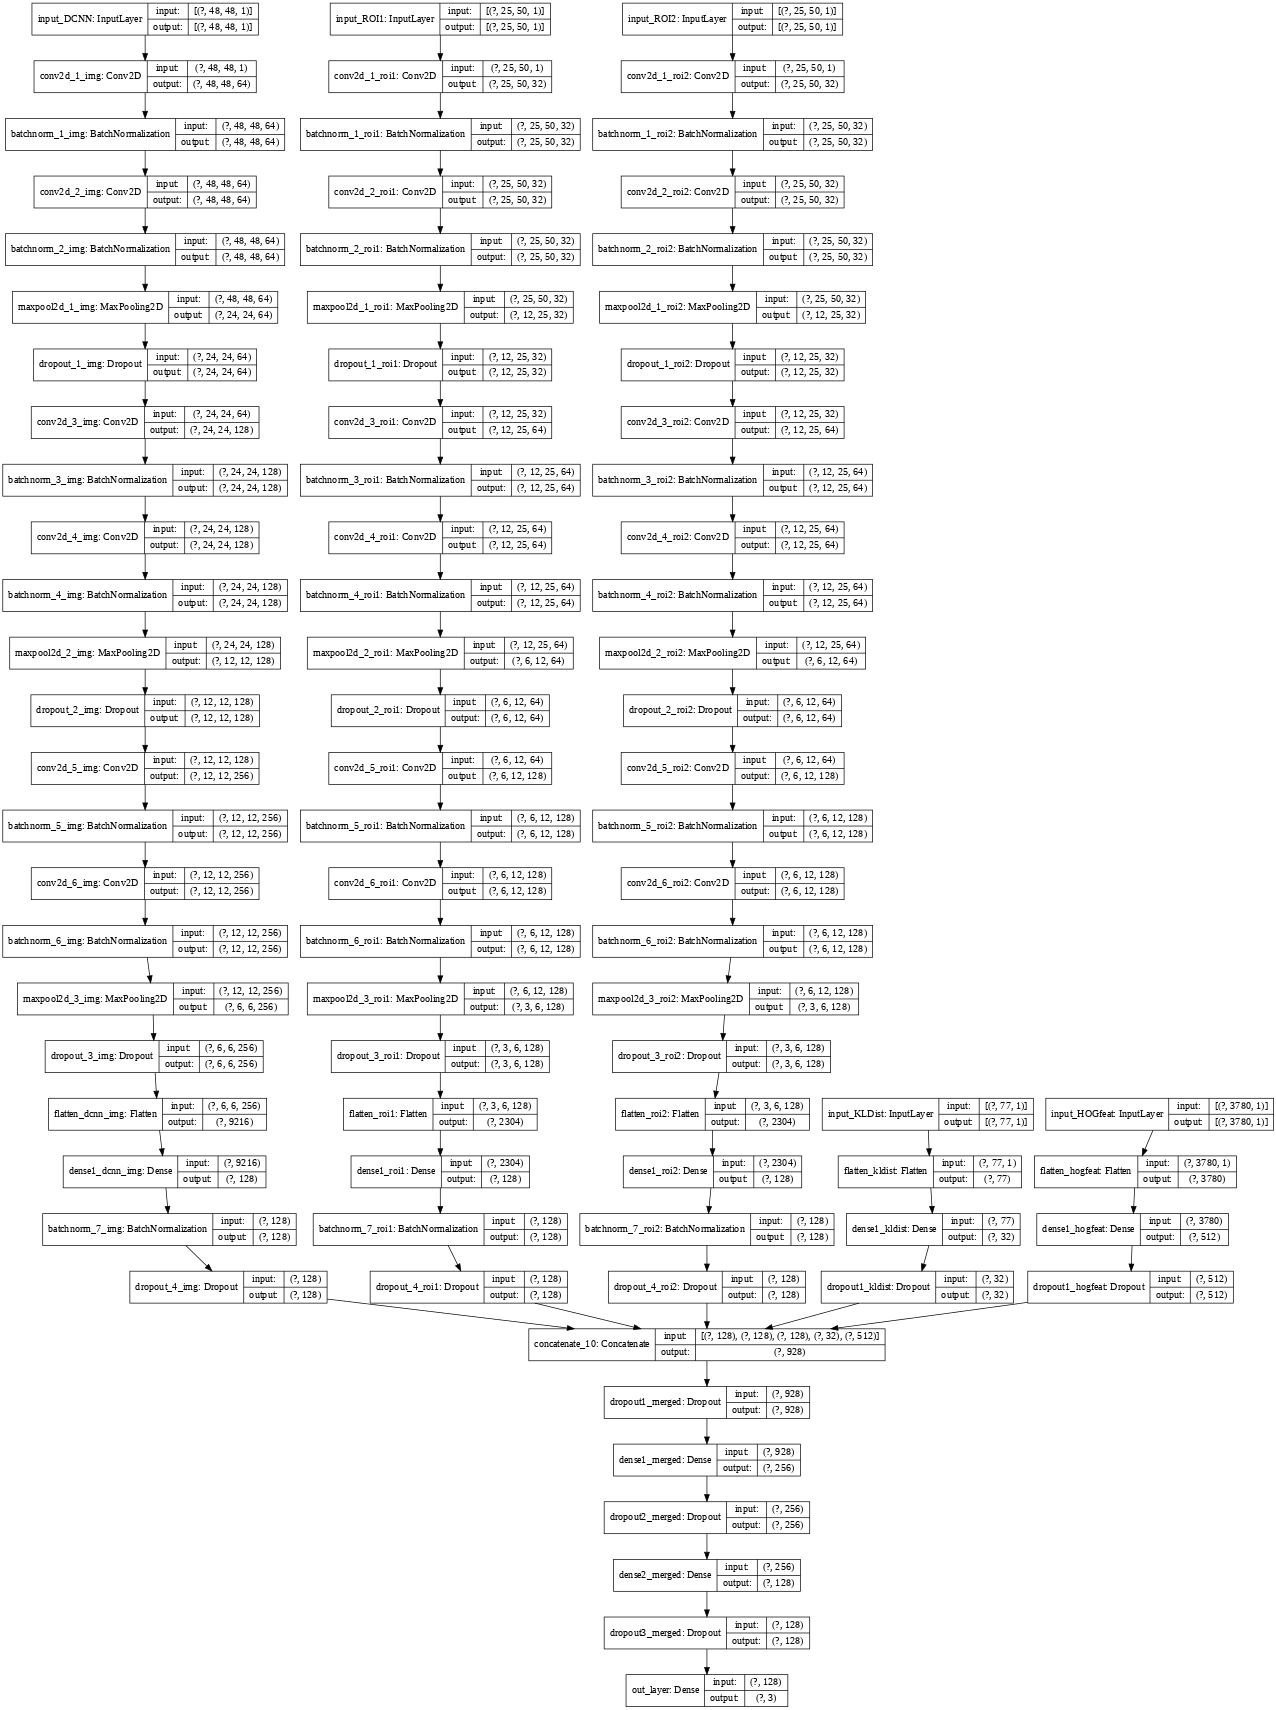

In [145]:
fullimg_in, fullimg_out = full_image_pipeline(input_shape=(48,48,1))
roi1_in, roi1_out = roi1_pipeline(input_shape=(*ROI_shape[::-1],1))
roi2_in, roi2_out = roi2_pipeline(input_shape=(*ROI_shape[::-1],1))
kldist_in, kldist_out = keylandmarks_distance_pipeline(input_shape=(77,1))
hogfeat_in, hogfeat_out = facial_HOGfeat_pipeline(input_shape=(3780,1))

num_classes = y_train.shape[1]

model = merge_models(
    models_in=[fullimg_in, roi1_in, roi2_in, kldist_in, hogfeat_in],
    models_out=[fullimg_out, roi1_out, roi2_out, kldist_out, hogfeat_out],
    num_classes=num_classes,
)

model_name = "img+roi1+roi2+kldist+hogfeat"
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True,
           dpi=50, to_file=BASE_PATH+f'architectures/{model_name}_model_{DATA}.png')

In [0]:
def data_generator_1(Xtrain_img, Xtrain_roi1, Xtrain_roi2, Xtrain_hogfeat, ytrain, batch_size):
    while True:
        idx = np.random.permutation(Xtrain_img.shape[0])

        datagen_img = ImageDataGenerator(
            rotation_range=15,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True,
        )

        datagen_roi = ImageDataGenerator(
            rotation_range=8,
            width_shift_range=0.08,
            height_shift_range=0.08,
            shear_range=0.08,
            zoom_range=0.08,
            horizontal_flip=True,
        )

        batches_img = datagen_img.flow(Xtrain_img[idx], ytrain[idx], batch_size=batch_size, shuffle=False, seed=42)
        batches_roi1 = datagen_roi.flow(Xtrain_roi1[idx], ytrain[idx], batch_size=batch_size, shuffle=False, seed=42)
        batches_roi2 = datagen_roi.flow(Xtrain_roi2[idx], ytrain[idx], batch_size=batch_size, shuffle=False, seed=42)

        idx0 = 0
        for batchimg, batchroi1, batchroi2 in zip(batches_img, batches_roi1, batches_roi2):
            idx1 = idx0 + batchimg[0].shape[0]

            yield [batchimg[0], batchroi1[0], batchroi2[0], Xtrain_hogfeat[idx[idx0:idx1]] ], batchimg[1]

            idx0 = idx1
            if idx1 >= Xtrain_img.shape[0]:
                break


def data_generator_2(Xtrain_img, Xtrain_roi1, Xtrain_roi2, Xtrain_kldist, Xtrain_hogfeat, ytrain, batch_size):
    while True:
        idx = np.random.permutation(Xtrain_img.shape[0])

        datagen = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.15,
            height_shift_range=0.15,
            shear_range=0.15,
            zoom_range=0.15,
            horizontal_flip=True,
        )

        batches = datagen.flow(Xtrain_img[idx], ytrain[idx], batch_size=batch_size, shuffle=False)

        idx0 = 0
        for batch in batches:
            idx1 = idx0 + batch[0].shape[0]

            yield [batch[0], Xtrain_roi1[idx[idx0:idx1]], Xtrain_roi2[idx[idx0:idx1]], Xtrain_kldist[idx[idx0:idx1]], Xtrain_hogfeat[idx[idx0:idx1]] ], batch[1]

            idx0 = idx1
            if idx1 >= Xtrain_img.shape[0]:
                break

In [0]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00001,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.00008,
    factor=0.25,
    patience=4,
    min_lr=1e-6,
    verbose=1,
)

callbacks = [
    # early_stopping,
    lr_scheduler,
]

In [139]:
batch_size = 16
epochs = 50
lr = 0.001
optim = optimizers.Adam(learning_rate=lr)

model.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
)

history = model.fit(
    data_generator_2(Xtrain_img, Xtrain_roi1, Xtrain_roi2, Xtrain_kldist, Xtrain_hogfeat, y_train, batch_size=batch_size,),
    # x = [Xtrain_img, Xtrain_roi1, Xtrain_roi2, Xtrain_kldist],
    # y = y_train,
    validation_data=([Xtest_img, Xtest_roi1, Xtest_roi2, Xtest_kldist, Xtest_hogfeat], y_test),
    steps_per_epoch=len(Xtrain_img) / batch_size,
    # batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
226/225 [==============================] - 6s 26ms/step - loss: 2.0044 - accuracy: 0.4427 - val_loss: 0.8913 - val_accuracy: 0.5723 - lr: 0.0010
Epoch 2/50
226/225 [==============================] - 5s 24ms/step - loss: 1.0646 - accuracy: 0.5457 - val_loss: 0.6973 - val_accuracy: 0.6258 - lr: 0.0010
Epoch 3/50
226/225 [==============================] - 5s 23ms/step - loss: 0.9291 - accuracy: 0.5868 - val_loss: 0.7659 - val_accuracy: 0.6211 - lr: 0.0010
Epoch 4/50
226/225 [==============================] - 5s 23ms/step - loss: 0.8408 - accuracy: 0.6076 - val_loss: 0.6397 - val_accuracy: 0.7107 - lr: 0.0010
Epoch 5/50
226/225 [==============================] - 5s 23ms/step - loss: 0.7860 - accuracy: 0.6309 - val_loss: 0.6557 - val_accuracy: 0.6619 - lr: 0.0010
Epoch 6/50
226/225 [==============================] - 5s 24ms/step - loss: 0.7293 - accuracy: 0.6537 - val_loss: 0.6197 - val_accuracy: 0.6903 - lr: 0.0010
Epoch 7/50
226/225 [==============================] - 5s 24ms/st

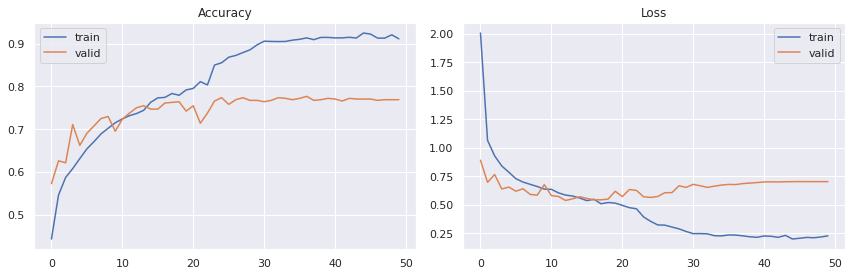

In [143]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(history.epoch, history.history['accuracy'], label='train')
sns.lineplot(history.epoch, history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(history.epoch, history.history['loss'], label='train')
sns.lineplot(history.epoch, history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig(BASE_PATH + f'epoch_metrics/{model_name}_{num_classes}emo_{DATA}.png')
pyplot.show()

In [141]:
label_to_text, text_to_label

({0: 'Happy', 1: 'Sadness', 2: 'Neutral'},
 {'Happy': 0, 'Neutral': 2, 'Sadness': 1})

test accuracy: 76.8868 %


              precision    recall  f1-score   support

           0       0.91      0.89      0.90       295
           1       0.65      0.57      0.61       156
           2       0.65      0.75      0.70       185

    accuracy                           0.77       636
   macro avg       0.74      0.73      0.73       636
weighted avg       0.77      0.77      0.77       636



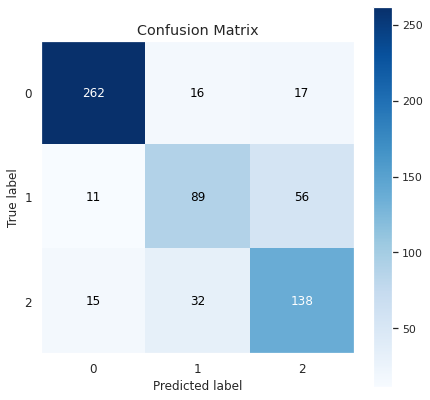

In [144]:
yhat_test = model.predict([Xtest_img, Xtest_roi1, Xtest_roi2, Xtest_kldist, Xtest_hogfeat])
yhat_test = np.argmax(yhat_test, axis=1)
ytest_ = np.argmax(y_test, axis=1)

scikitplot.metrics.plot_confusion_matrix(ytest_, yhat_test, figsize=(7,7))
pyplot.savefig(BASE_PATH + f'confusion_matrix/{model_name}_{num_classes}emo_{DATA}.png')

test_accu = np.sum(ytest_ == yhat_test) / len(ytest_) * 100
print(f"test accuracy: {round(test_accu, 4)} %\n\n")

print(classification_report(ytest_, yhat_test))